<a href="https://colab.research.google.com/github/kavehkarimadini/ARC_101_Time_Series_NoteBooks/blob/master/Temperature_Forecast_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#Read Data

In [2]:
df=pd.read_csv('/content/MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (1821, 5)


,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


#Plot Your Data

<Axes: xlabel='DATE'>

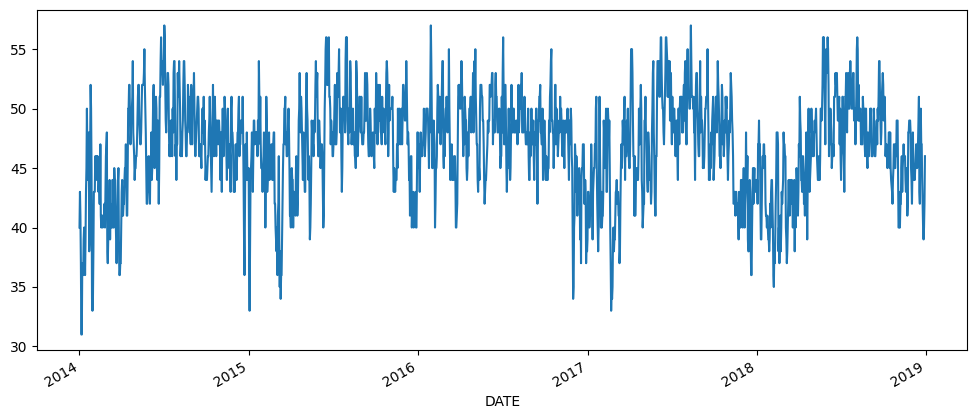

In [3]:
df['AvgTemp'].plot(figsize=(12,5))

# Lagged features

### **What are Lagged Features?**
Lagged features are previous values of a time series used as input features to predict future values. They capture temporal dependencies in the data.

For example:
- If you have a temperature time series `AvgTemp = [43, 45, 46, 48, 50]`,
- Creating lagged features (with `lags=2`) would generate:
  ```
  AvgTemp  lag_1  lag_2
  46       45     43
  48       46     45
  50       48     46
  ```

---

### **Code Explanation**

- **`shift(lag)`**: Creates a new column where each value is shifted down by `lag` steps, effectively creating "lagged" values of the time series.
  - For `lag_1`, each value in the new column is the previous value of `AvgTemp`.
  - For `lag_2`, each value is the value two steps earlier, and so on.
  
- **`dropna()`**: Removes rows with missing values. Lagging causes missing values at the start of the dataset because there are no previous values to shift.

---

#### 2. **Apply the Function**: `lagged_df = create_lagged_features(df, lags=3)`

- **Input DataFrame**: Suppose `df` looks like this:
  ```
  AvgTemp
  43
  45
  46
  48
  50
  ```

- **Step 1: Add Lagged Columns**:
  After `shift(lag)`, the new DataFrame will look like this (before dropping `NaN`):
  ```
  AvgTemp  lag_1  lag_2  lag_3
  43       NaN    NaN    NaN
  45       43.0   NaN    NaN
  46       45.0   43.0   NaN
  48       46.0   45.0   43.0
  50       48.0   46.0   45.0
  ```

- **Step 2: Drop Rows with `NaN`**:
  After `dropna()`, the DataFrame becomes:
  ```
  AvgTemp  lag_1  lag_2  lag_3
  48       46.0   45.0   43.0
  50       48.0   46.0   45.0
  ```

---

### **Purpose of the Code**

- The goal is to prepare the time series for **supervised learning**, where:
  - **Features**: The lagged values (`lag_1`, `lag_2`, ..., `lag_n`).
  - **Target**: The current value (`AvgTemp`).
  
- This transformed data can then be used as input to machine learning models (e.g., XGBoost, Random Forest, or Linear Regression) to predict the next value in the series.

---

In [4]:
# Create lagged features
def create_lagged_features(data, lags=3):
    df = pd.DataFrame(data)
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df["AvgTemp"].shift(lag)
    df.dropna(inplace=True)
    return df

In [5]:
# Apply lagged features function
lagged_df = create_lagged_features(df, lags=3)

# Split into features and target
X = lagged_df.drop("AvgTemp", axis=1)
y = lagged_df["AvgTemp"]

In [6]:
X

,MinTemp,MaxTemp,Sunrise,Sunset,lag_1,lag_2,lag_3
DATE,,,,,,,
2014-01-04,32.0,41.0,658,1757,41.0,43.0,40.0
2014-01-05,24.0,38.0,658,1758,37.0,41.0,43.0
2014-01-06,22.0,39.0,658,1759,31.0,37.0,41.0
2014-01-07,28.0,45.0,658,1759,31.0,31.0,37.0
2014-01-08,30.0,41.0,659,1800,37.0,31.0,31.0
...,...,...,...,...,...,...,...
2018-12-26,35.0,45.0,654,1752,42.0,44.0,47.0
2018-12-27,33.0,44.0,655,1752,40.0,42.0,44.0
2018-12-28,33.0,47.0,655,1753,39.0,40.0,42.0


In [7]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

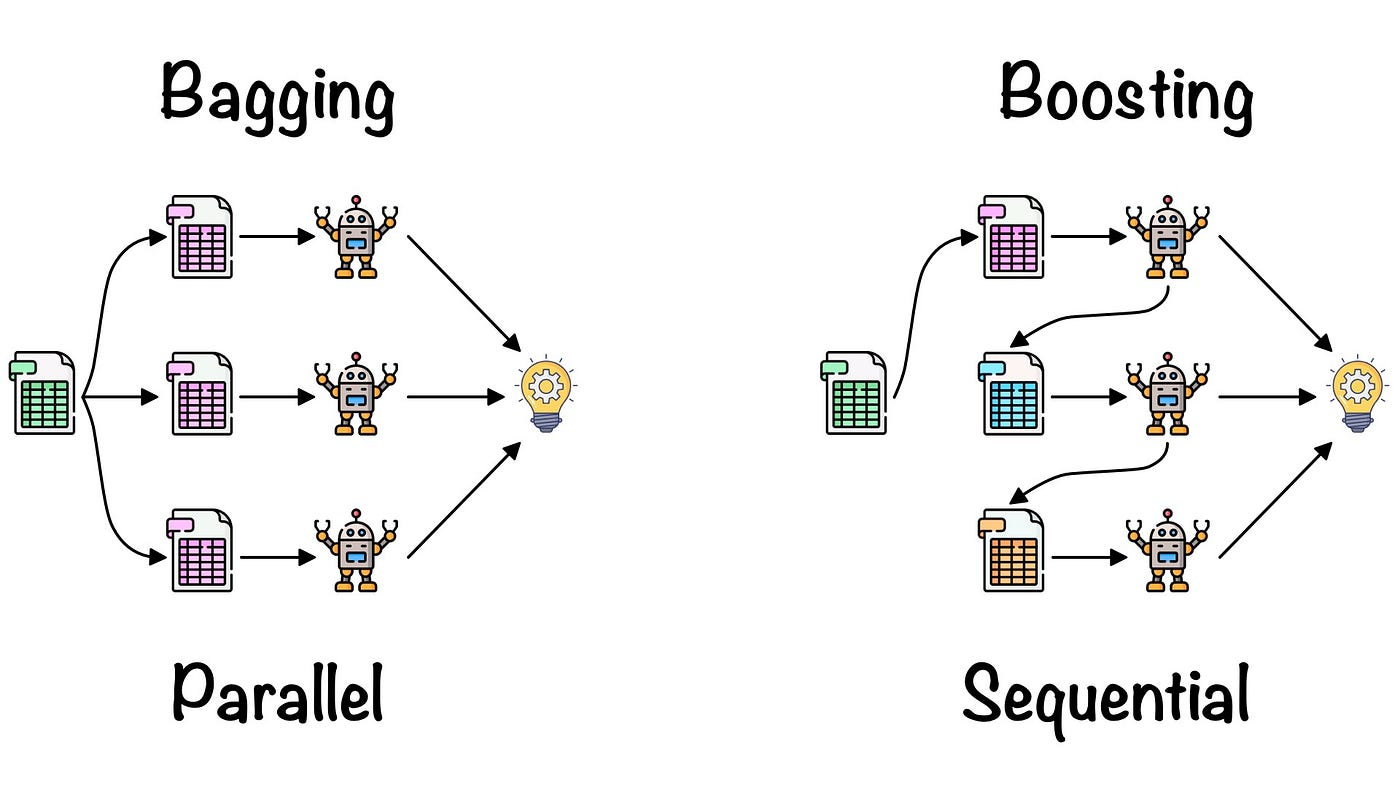

### **Difference Between Bagging and Boosting**

#### **Bagging (Bootstrap Aggregating):**
1. **Purpose:** Reduces variance by training multiple models independently on different random subsets of data and averaging their predictions.
2. **Approach:**
   - Uses random sampling with replacement to create subsets of the data.
   - All models are trained in parallel (e.g., Random Forest).
   - Combines predictions by majority voting (classification) or averaging (regression).
3. **Key Property:** Models are trained **independently**, and it focuses on reducing **overfitting**.

#### **Boosting:**
1. **Purpose:** Reduces bias and variance by training models sequentially, where each model improves upon the mistakes of the previous one.
2. **Approach:**
   - Models are trained one after another, focusing on errors made by the previous models.
   - Combines predictions using weighted votes or sums.
3. **Key Property:** Models are trained **sequentially**, and it focuses on reducing **bias** and improving **accuracy**.

---

### **XGBoost Algorithm Step-by-Step**

XGBoost is a **boosting algorithm** that uses gradient boosting with advanced optimizations for speed and performance. It builds an ensemble of decision trees sequentially.

---

#### **Step 1: Initialize Predictions**
- Start with initial predictions for all data points. Typically, the mean of the target variable (`y_mean`) is used as the initial prediction.
  $
  y_{\text{pred}} = \bar{y}
  $
  
---

#### **Step 2: Calculate Residuals**
- Calculate the **residuals**, which represent the error between the actual and predicted values:
  $
  \text{Residual} = y_{\text{actual}} - y_{\text{pred}}
  $

The goal of each tree is to minimize these residuals.

---

#### **Step 3: Train a Decision Tree**
- Train a small, shallow decision tree (weak learner) to predict the **residuals**. Each tree tries to model where the current predictions are wrong.
- The decision tree partitions the feature space into regions where residuals are minimized.

---

#### **Step 4: Update Predictions**
- Update the predictions by adding the outputs of the decision tree multiplied by a learning rate $\eta$:
  $
  y_{\text{new}} = y_{\text{pred}} + \eta \cdot \text{TreeOutput}
  $
  
- The **learning rate** $\eta$ controls how much each tree contributes to the final model, preventing overfitting.

---

#### **Step 5: Calculate Loss Function**
- Compute the loss function, such as Mean Squared Error (MSE) for regression:
  $
  \text{Loss} = \frac{1}{n} \sum (y_{\text{actual}} - y_{\text{pred}})^2
  $
- Gradient Boosting minimizes this loss function iteratively.

---

#### **Step 6: Regularization (Optional)**
- **XGBoost includes regularization** techniques to prevent overfitting:
  - **L1 regularization (LASSO):** Adds a penalty for the sum of the absolute values of leaf weights.
  - **L2 regularization (Ridge):** Adds a penalty for the sum of the squared values of leaf weights.

---

#### **Step 7: Repeat for Multiple Trees**
- Repeat Steps 2–6 for a predefined number of trees or until the loss function converges.
- Each new tree corrects the errors made by the previous ensemble of trees.

---

#### **Final Prediction**
- Combine all the trees' predictions to produce the final output. In regression:
  $
  y_{\text{final}} = \sum \left( \eta \cdot \text{TreeOutput} \right)
  $

For classification, the predictions are transformed into probabilities (e.g., using a sigmoid function for binary classification).

---

### **Advantages of XGBoost**
1. **Regularization:** Prevents overfitting using L1 and L2 regularization.
2. **Weighted Residuals:** Assigns weights to misclassified samples, ensuring the algorithm focuses on harder examples.
3. **Parallelization:** Optimizes training by processing tree nodes in parallel.
4. **Handling Missing Data:** Can infer the best direction to split on missing values automatically.
5. **Sparsity-aware:** Efficiently handles sparse datasets with missing or zero values.

---

### Summary of the XGBoost Workflow:
1. Initialize predictions with the mean.
2. Calculate residuals (errors).
3. Fit a weak learner (decision tree) to residuals.
4. Update predictions using the tree's output and a learning rate.
5. Regularize to avoid overfitting.
6. Repeat for multiple iterations.
7. Combine all trees for final predictions.

In [8]:
# Initialize the XGBoost Regressor
# Define XGBoost model with regularization
model = XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    n_estimators=100,              # Number of trees
    learning_rate=0.1,             # Learning rate (eta)
    max_depth=3,                   # Maximum depth of each tree
    reg_lambda=1,                  # L2 regularization term
    reg_alpha=0,                   # L1 regularization term
    gamma=1,                       # Minimum loss reduction for split
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 0.34567154747424805


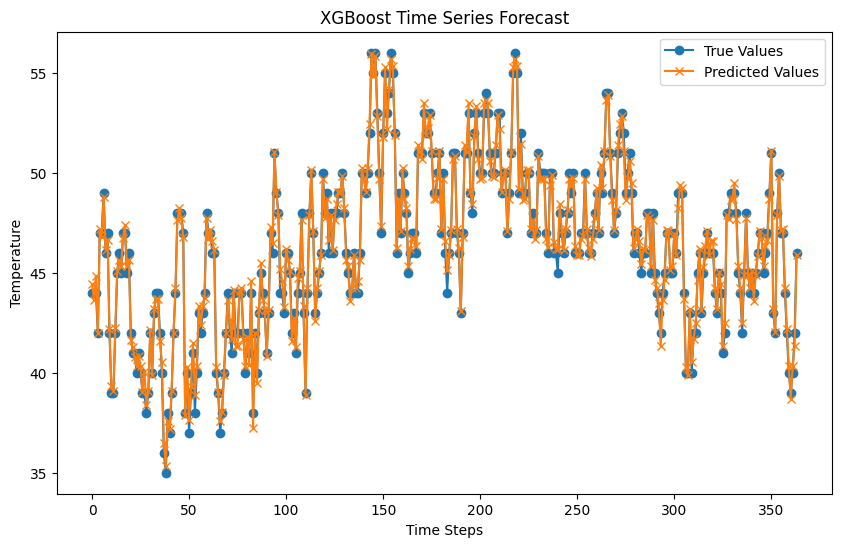

In [9]:
import matplotlib.pyplot as plt

# Plot the true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test.values, label="True Values", marker="o")
plt.plot(range(len(y_pred)), y_pred, label="Predicted Values", marker="x")
plt.legend()
plt.title("XGBoost Time Series Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.show()


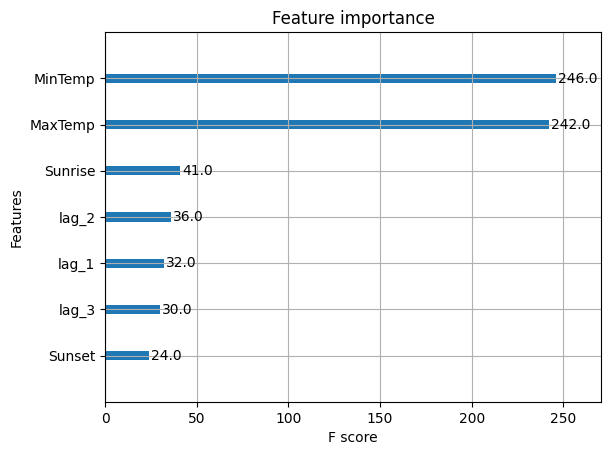

In [ ]:
# Plot feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()
